In [268]:
# Librerie base
import numpy as np
import pandas as pd

# Visualizzazione
import matplotlib.pyplot as plt  
import seaborn as sns

# Modelli statistici
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

# Libreria ISLP (Statistical Learning)
from ISLP import load_data
from ISLP.models import (ModelSpec as MS ,summarize, poly)

# Simple Linear Regression
We will use the Boston housing dataset, contained in the ISLP package. The Boston dataset records the medv (average house value) for 506 neighbourhoods around Boston.

In [269]:
# carico il dataset e stampo l'head
car = pd.read_csv("CarPrice_Assignment.csv", encoding='utf-8')

In [270]:
car.columns

Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price'],
      dtype='object')

In [271]:
#look at the first 5 rows in the datasets
car.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [272]:
print(car.describe())

           car_ID   symboling   wheelbase   carlength    carwidth   carheight  \
count  205.000000  205.000000  205.000000  205.000000  205.000000  205.000000   
mean   103.000000    0.834146   98.756585  174.049268   65.907805   53.724878   
std     59.322565    1.245307    6.021776   12.337289    2.145204    2.443522   
min      1.000000   -2.000000   86.600000  141.100000   60.300000   47.800000   
25%     52.000000    0.000000   94.500000  166.300000   64.100000   52.000000   
50%    103.000000    1.000000   97.000000  173.200000   65.500000   54.100000   
75%    154.000000    2.000000  102.400000  183.100000   66.900000   55.500000   
max    205.000000    3.000000  120.900000  208.100000   72.300000   59.800000   

        curbweight  enginesize   boreratio      stroke  compressionratio  \
count   205.000000  205.000000  205.000000  205.000000        205.000000   
mean   2555.565854  126.907317    3.329756    3.255415         10.142537   
std     520.680204   41.642693    0.270844

In [273]:
# Controllo i dati nulli
columnsWithNulls=car.isnull().sum().sort_values(ascending=False)
columnsWithNulls=columnsWithNulls[columnsWithNulls>0]
print(columnsWithNulls)

Series([], dtype: int64)


Series([], dtype: float64)


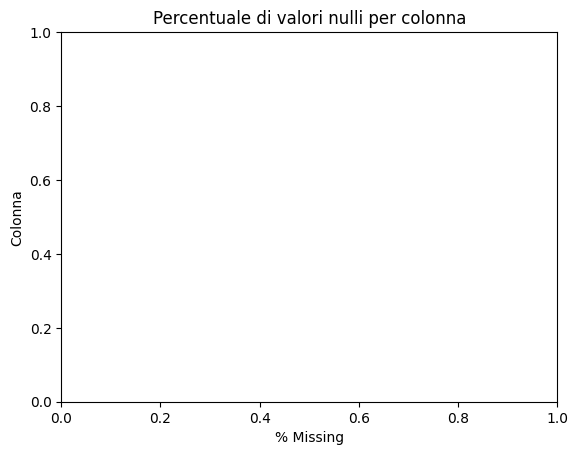

In [274]:
# Controllo in percentuale quanti dati mancano così da capire come trattarli, pongo una soglia di eliminazione del regressore nel caso di +30% di dati mancanti
missing_pct = car.isnull().mean() * 100
missing_only = missing_pct[missing_pct > 0].sort_values(ascending=False)
print(missing_only)
sns.barplot(x=missing_only.values, y=missing_only.index)
plt.title('Percentuale di valori nulli per colonna')
plt.xlabel('% Missing')
plt.ylabel('Colonna')
plt.show()

In [275]:
# 5. Droppa idcar
car.drop(columns=['car_ID'], inplace=True)

## Data processing

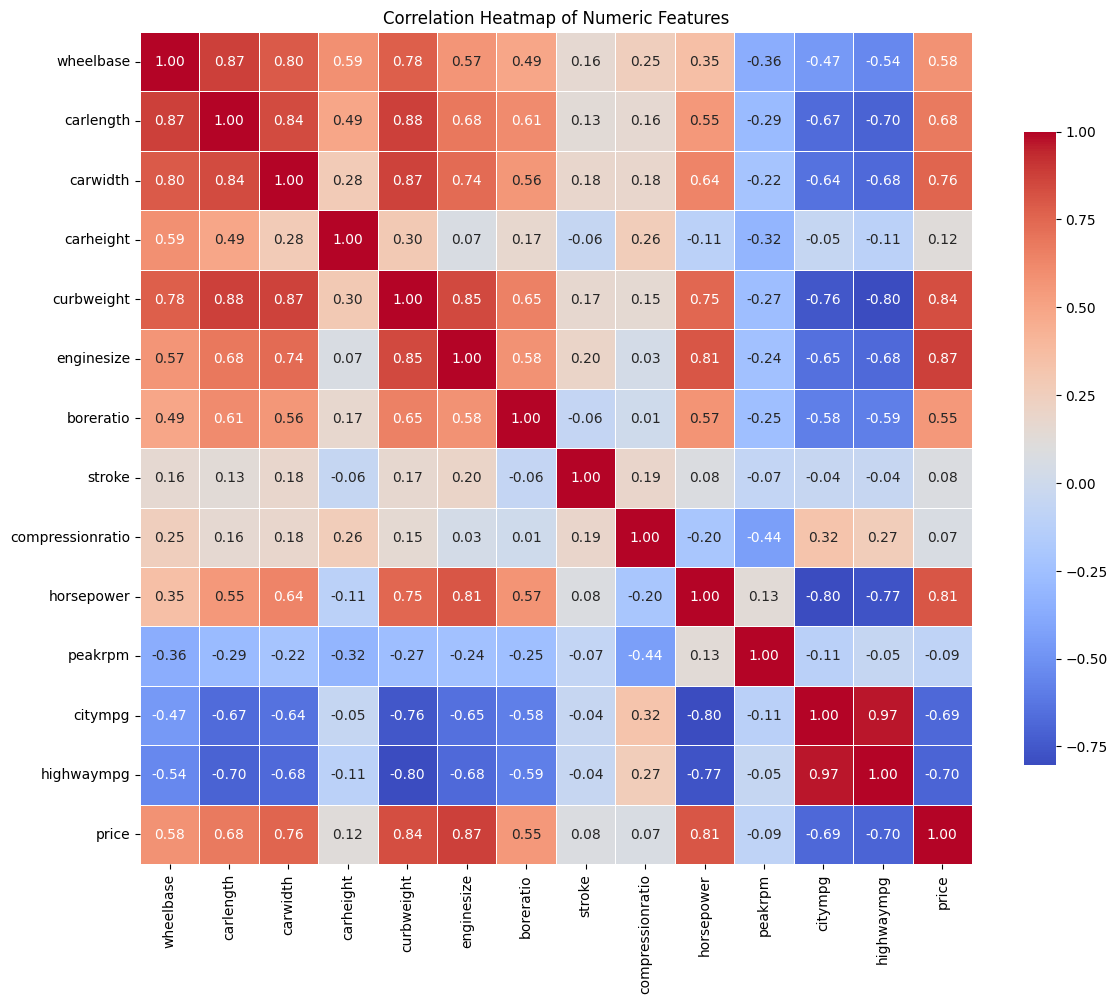

In [279]:
# Seleziona le colonne numeriche
numeric_car = car.select_dtypes(include=[np.number])
#drop delle variabili categoriche 
numeric_car.drop(columns=['symboling'], inplace=True)
# Controllo che ci siano almeno 4 variabili numeriche per evitare visualizzazioni poco utili
if numeric_car.shape[1] >= 4:
    # Calcola la matrice di correlazione
    corr = numeric_car.corr()
    
    # Imposta la figura
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        square=True,
        linewidths=.5,
        cbar_kws={"shrink": .75}
    )
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for a meaningful correlation heatmap')

In [277]:
# 1. Seleziona solo le colonne numeriche e calcola la correlazione assoluta
corr = numeric_car.corr().abs()

# 2. Prendi la metà superiore (senza diagonale)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# 3. Trova tutte le colonne con correlazione > 0.90
to_drop = upper.columns[upper.gt(0.60).any()].tolist()
print("Tutte le colonne candidate al drop:", to_drop)

# 4. Rimuovi 'Driver Aggression Score' dalla lista, se presente
to_drop = [col for col in to_drop if col != "price"]
print("Colonne da droppare (escl. price):", to_drop)

#magari potremmo fare un drop di chi ha un valore di correlazione > 0.90 ?????
# 5. Droppa le colonne selezionate
numeric_car.drop(columns=to_drop, inplace=True)
# 6. Controlla le colonne rimaste
print("Colonne rimaste dopo il drop:", car.columns.tolist())

Tutte le colonne candidate al drop: ['carlength', 'carwidth', 'curbweight', 'enginesize', 'boreratio', 'horsepower', 'citympg', 'highwaympg', 'price']
Colonne da droppare (escl. price): ['carlength', 'carwidth', 'curbweight', 'enginesize', 'boreratio', 'horsepower', 'citympg', 'highwaympg']
Colonne rimaste dopo il drop: ['symboling', 'CarName', 'fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price']


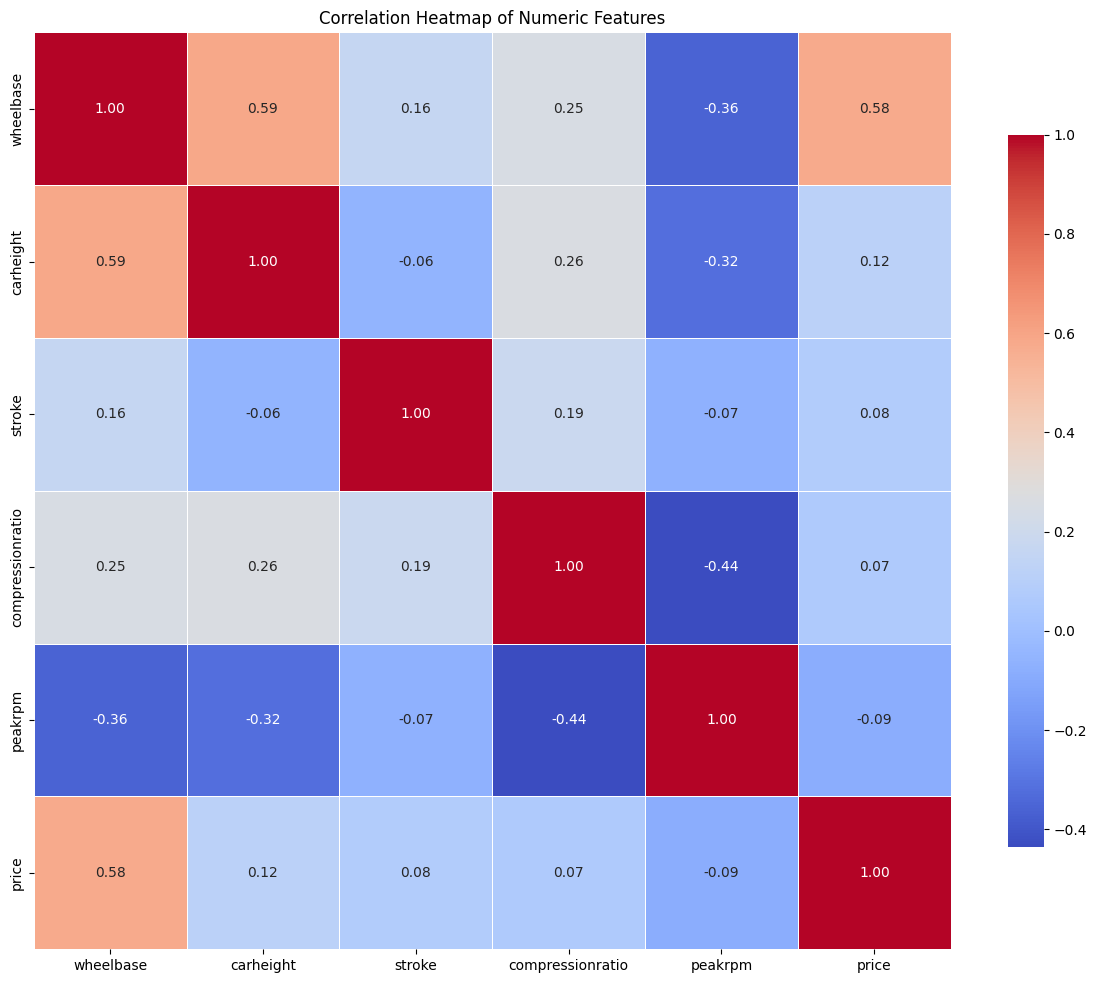

In [278]:
# Ristampiamo 

    # Calcola la matrice di correlazione
corr = numeric_car.corr()
    
    # Imposta la figura
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .75}
    )
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) Prepara X con le sole colonne numeriche (escl. target e log_Aggression)
X = numeric_car
X = X.drop(columns=['price'])

# 2) Calcola il VIF per ogni variabile
vif_data = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) 
            for i in range(X.shape[1])]
})

# 3) Ordina e stampa
vif_data = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)
print(vif_data)



In [ ]:

x_vars = [col for col in numeric_car if col != 'price']

# Controlla se ci sono abbastanza variabili da visualizzare
n = len(x_vars)
if n > 0:
    # Imposta il layout della figura
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 5), sharey=True)

    # Scatterplot di ogni variabile rispetto al Driver Aggression Score
    for i, var in enumerate(x_vars):
        sns.scatterplot(data=car, x=var, y='price', ax=axes[i])
        axes[i].set_title(f'{var} vs price')
        axes[i].set_xlabel(var)

    axes[0].set_ylabel('price')
    plt.tight_layout()
    plt.show()
else:
    print('Nessuna variabile numerica disponibile per il confronto con price')

## Linear model

In [ ]:
numeric_car

### Choose the first 3 variables that are more promising

In [ ]:
# Target variable
target = 'price'

results = []

# Looping every possible variable
for col in numeric_car:
    X = sm.add_constant(car[[col]])
    y = car[target]
    
    model = sm.OLS(y, X).fit()
    
    results.append({
        'variable': col,
        'r_squared': model.rsquared,
        'p_value': model.pvalues[col]
    })

# Transforming data frame
results_df = pd.DataFrame(results)

# Ordering
top_r2_pval = results_df.sort_values(by='p_value', ascending=True).head(4)
worse_r2_pval = results_df.sort_values(by='p_value', ascending=False).head(3)


# Output
print("VARIABILI CON R² PIU' ALTO E p-value PIU BASSO:")
print(top_r2_pval)

print("\n\nVARIABILI CON R² PIU' BASSO E p-value PIU ALTO:\n")
print(worse_r2_pval)

### Fit Linear Model: mdev = b0 + b1*enginesize + e

In [ ]:
X = pd.DataFrame({'intercept': np.ones(car.shape[0]), 'enginesize': car['enginesize']})
X[:4]

In [ ]:
y = car[target]
model = sm.OLS(y, X) #function to fit a simple linear regression. Here we define the model
results = model.fit() #here we fit the model

In [ ]:
print(results.summary())

significant_vars = results.pvalues[results.pvalues < 0.05]
print("\nVariabili significative (p-value < 0.05):")
print(significant_vars)

insignificant_vars = results.pvalues[results.pvalues >= 0.05]
print("\nVariabili insignificanti (p-value >= 0.05):")
print(insignificant_vars)

### Creating the input matrix using ModelSpec of ISLP package

In [ ]:
model = MS(['enginesize'])
model = model.fit(car) 
X = model.transform(car)
X[:4]

In [ ]:
sns.histplot(y, kde=True)

plt.xlim(y.quantile(0.00), y.quantile(0.95))

plt.title('Distribution of price (Up to 95th Percentile)')
plt.show()

In [ ]:
sns.histplot(car['enginesize'], kde=True)


plt.title('Distribution of enginesize')
plt.show()

In [ ]:
# Get predictions on new input
new_df = pd.DataFrame({'enginesize': [130, 140, 170, 163, 157, 195]})
new_X = model.transform(new_df)  # Aggiungi una colonna di 1 per l'intercetta
new_X

In [ ]:
New_X = sm.add_constant(new_df)
new_predictions = results.get_prediction(new_X)
predicted_means = new_predictions.predicted_mean
print(predicted_means)

In [ ]:
#Confidence interval
new_predictions.conf_int(alpha=0.05)

In [ ]:
intercept = results.params.iloc[0]  # Intercetta (b)
slope = results.params.iloc[1]  # Pendenza (m)

formula = f"y = {slope:.4f} * enginesize + {intercept:.4f}"

print("FORMULA del modello di regressione:", formula)

In [ ]:
def abline(ax, b, m, *args, **kwargs):
    "Aggiungi una retta con pendenza m e intercetta b su ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

ax = plt.gca()
ax.scatter(car['enginesize'], car['price'])

abline(ax, intercept, slope, 'r--', linewidth=3)

plt.show()

In [ ]:
# Diagnostics plot (We observe non linearity)
fig, ax = plt.subplots(figsize=(8, 8)) 
ax.scatter(results.fittedvalues, results.resid)  # Scatter plot of fitted values vs residuals
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')  


In [ ]:
# Compute leverage statistics
infl = results.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)

In [ ]:
# ─── LASSO REGRESSION ──────────────────────────────────────────────────────────

# 1) Importa le librerie necessarie
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# 2) Prepara X e y
#    qui numeric_car è il DataFrame con le sole variabili numeric e senza 'price'
X = numeric_car.drop(columns=['price'])
y = car['price']

# 3) Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# 4) Costruisci una Pipeline con StandardScaler + LassoCV
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso_cv', LassoCV(cv=5, random_state=0, max_iter=10_000))
])

# 5) Allena il modello
pipe.fit(X_train, y_train)

# 6) Estrai α ottimo e coefficienti
best_alpha = pipe.named_steps['lasso_cv'].alpha_
coefs = pd.Series(
    pipe.named_steps['lasso_cv'].coef_,
    index=X.columns
).sort_values()

print(f"Best α (LassoCV): {best_alpha:.4f}")
print("\nCoefficienti Lasso (alcuni a zero se eliminati):")
print(coefs)

# 7) Valuta su test set
y_pred = pipe.predict(X_test)
print(f"\nTest R²:  {r2_score(y_test, y_pred):.3f}")

# 8) (Opzionale) Cross-validation score medio
cv_r2 = cross_val_score(pipe, X, y, cv=5, scoring='r2')
print(f"\n5-fold CV mean R²: {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")


In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Pipeline (scaler + Lasso)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso_cv', LassoCV(
        alphas=np.logspace(-3, 3, 100),
        cv=5,
        max_iter=20_000,
        random_state=0
    ))
])

pipe.fit(X_train, y_train)

print("Alfa ottimo:", pipe.named_steps['lasso_cv'].alpha_)
coeffs = pd.Series(
    pipe.named_steps['lasso_cv'].coef_,
    index=X.columns
)
print("\nCoefficenti selezionati:\n", coeffs[coeffs!=0])


In [ ]:
from sklearn.linear_model import lasso_path

Xs = StandardScaler().fit_transform(X)
alphas, coefs, _ = lasso_path(Xs, y, alphas=np.logspace(-3, 3, 200))

plt.figure(figsize=(6,4))
for coef in coefs:
    plt.plot(alphas, coef)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.xlabel('α')
plt.ylabel('Coefficiente')
plt.title('Lasso path')
plt.show()


In [ ]:
from sklearn.linear_model import ElasticNetCV

pipe_en = Pipeline([
    ('scaler', StandardScaler()),
    ('en', ElasticNetCV(
        l1_ratio=[.1, .5, .9],  # mix L1/L2
        alphas=np.logspace(-3, 3, 50),
        cv=5,
        random_state=0
    ))
])
pipe_en.fit(X_train, y_train)
print("Best α:", pipe_en.named_steps['en'].alpha_,
      "– l1_ratio:", pipe_en.named_steps['en'].l1_ratio_)


# Coefficienti
coefs_en = pd.Series(
    pipe_en.named_steps['en'].coef_,
    index=X.columns
).sort_values()

print("\nCoefficienti ElasticNet (alcuni a zero se eliminati):")

print(coefs_en)
# Valutazione
y_pred_en = pipe_en.predict(X_test)
print(f"\nTest R²:  {r2_score(y_test, y_pred_en):.3f}")



# Multiple Linear Regression

In [ ]:
# y = b*X + e (perform a regression using all of the predictors)
terms = numeric_car.drop(columns=['price'])
print(terms.columns)

In [ ]:
X = MS(terms).fit_transform(car)
model = sm.OLS(y, X)
results = model.fit()
summarize(results)

In [ ]:
significant_vars = results.pvalues[results.pvalues < 0.05]
print("\nVariabili significative (p-value < 0.05):")
print(significant_vars)

insignificant_vars = results.pvalues[results.pvalues >= 0.05]
print("\nVariabili insignificanti (p-value >= 0.05):")
print(insignificant_vars)

In [ ]:
# getting goodness of fit
print("R2", results.rsquared)
print("RSE", np.sqrt(results.scale))

In [ ]:
minus_var = terms.drop(['Season', 'Round', 'Track_Temp_C', 'Humidity_%', 'Stint', 'Stint Length'])
Xma = MS(minus_var).fit_transform(f1)
model1 = sm.OLS(y, Xma)
results1 = model1.fit()
summarize(results1)

In [ ]:
significant_vars = results1.pvalues[results1.pvalues < 0.05]
print("\nVariabili significative (p-value < 0.05):")
print(significant_vars)

insignificant_vars = results1.pvalues[results1.pvalues >= 0.05]
print("\nVariabili insignificanti (p-value >= 0.05):")
print(insignificant_vars)

In [ ]:
print("R2", results1.rsquared)
print("RSE", np.sqrt(results1.scale))

## Interaction Terms

In [ ]:
# to introduce and interactions terms use a python tuple
X = MS(['lstat', 'age', ('lstat', 'age')]).fit_transform(Boston)
model2 = sm.OLS(y, X)
summarize(model2.fit())

## Non-linear Transformations of the Predictors

In [ ]:
# poly() function present in the package ISLP specifies that columns representing polynomial functions of its first argument are added to the model matrix
X = MS([poly('lstat', degree=2), 'age']).fit_transform(Boston)
model3 = sm.OLS(y, X)
results3 = model3.fit()
summarize(results3)

## Qualitative predictors
Based on the Carseats dataset present in the package ISLP, will attempt to predict Sales (child car seat sales) in 400 locations based
on a number of predictors.

The Carseats data includes the qualitative predictor "ShelveLoc," which indicates the quality of the shelving location with three possible values: Bad, Medium, and Good.

In general for qualitative predictor the ModelSpec() generates one-hot encoding of the categorical variables automatically

In [ ]:
Carseats = load_data('Carseats')
Carseats.columns

In [ ]:
allvars = list(Carseats.columns.drop('Sales'))
y = Carseats['Sales']
final = allvars + [('Income', 'Advertising'),
('Price', 'Age')]
X = MS(final).fit_transform(Carseats)
model = sm.OLS(y, X)
summarize(model.fit())

# Cross Validation

### Validation set approach

In [ ]:
from functools import partial
from sklearn.model_selection import (cross_validate ,KFold ,ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm #a wrapper that enables us to easily use the cross-validation tools of sklearn with models fit by statsmodels
from sklearn.model_selection import train_test_split

In [ ]:
Auto = load_data('Auto')
Auto_train , Auto_valid = train_test_split(Auto, test_size=196, random_state=0) # random_state is needed for reproducible result across run

In [ ]:
#fit a linear regression model
hp_mm = MS(['horsepower'])
X_train = hp_mm.fit_transform(Auto_train)
y_train = Auto_train['mpg']
model = sm.OLS(y_train , X_train)
results = model.fit()

In [ ]:
# evaluate the model using the MSE on the validation data
X_valid = hp_mm.transform(Auto_valid)
y_valid = Auto_valid['mpg']
valid_pred = results.predict(X_valid)
np.mean((y_valid - valid_pred)**2)

## Leave One-out Cross validation
The sklearn_sm() class takes a statsmodels model as its first argument. It also accepts two optional arguments: model_str for specifying a formula, and model_args, which is a dictionary containing additional arguments for fitting the model.

In [ ]:
hp_model = sklearn_sm(sm.OLS, MS(['horsepower']))
X, Y = Auto.drop(columns=['mpg']), Auto['mpg']

# This is a LOOCV because cv use the number of sample in our dataset, that is Auto.shape[0], making sure that each sample is use as a test set
cv_results = cross_validate(hp_model ,X, Y, cv=Auto.shape[0])
cv_err = np.mean(cv_results['test_score'])
cv_err

## K-Fold cross validation

In [ ]:
hp_model = sklearn_sm(sm.OLS, MS(['horsepower']))
X, Y = Auto.drop(columns=['mpg']), Auto['mpg']
kf = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_validate(hp_model, X, Y, cv=kf)
cv_err = np.mean(cv_results['test_score'])
cv_err

# Exercise
Train and compare the performance of different cross-validation methods to identify the best model for polynomial regression with varying degrees using the Auto dataset.

https://scikit-learn.org/stable/

Fine